In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import os

from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts

In [3]:
import pandas as pd
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [4]:
df= pd.read_csv('Data-NLP/movie_reviews_v2.csv')
df

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0
...,...,...,...,...,...,...
8645,64ba5c5706f98400e1169ed0,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,"I'm not really a great fan of Tom Cruise. Yes,...",7.0
8646,64bdab4dad50f0013b127c02,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,Spectacular cinematic action let down by an in...,6.0
8647,64cca28c43cd5400add62db6,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,The Tom Cruise “Mission Impossible” franchise ...,9.0
8648,652e4978caef2d0139df3b6c,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,It was a good movie. Not better than the pervi...,8.0


In [5]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [6]:
def categorize_rating(rating):
    if rating >= 9:
        return 'High-rating'
    elif rating <= 4:
        return 'Low-rating'
    else:
        return None

In [7]:
df['target'] = df['rating'].apply(categorize_rating)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,target
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0,None
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0,None
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0,None
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0,None


In [8]:
df.dropna(subset=['target'], inplace=True)
df

,review_id,movie_id,imdb_id,original_title,review,rating,target
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low-rating
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low-rating
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High-rating
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low-rating
...,...,...,...,...,...,...,...
8629,6499e4de62f3350127477b22,569094,tt9362722,Spider-Man: Across the Spider-Verse,"I don't know, but in my humble opinion, the pu...",10.0,High-rating
8631,64cca1752f266b09ef121de5,569094,tt9362722,Spider-Man: Across the Spider-Verse,I don’t have that much to say about “Spider-Ma...,9.0,High-rating
8632,64de022bd100b614b2ef6547,569094,tt9362722,Spider-Man: Across the Spider-Verse,Incredible non stop action movie,10.0,High-rating
8639,6529c2000929f6010090f513,565770,tt9362930,Blue Beetle,"I mean, it's not bad. It has the message, but...",10.0,High-rating


In [ ]:
batch_preprocess_texts()

**NLTK and SpaCy for basic text processing**

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
# # For loop to remove stopwords
# cleaned_tokens = []
# # For each token 
# for token in doc:
    
#     # If the token is a stopword, skip it
#     if token.is_stop == True:
#         continue 
    
#     # Otherwise,
#     else: 
#         # keep the tokens'.text for the final list of tokens
#         cleaned_tokens.append(token.text.lower())
# print(cleaned_tokens)

In [11]:
# ## Adding onto our preprocessing for loop
# # For loop to remove stopwords & punctuation
# cleaned_tokens = []
# # For each token 
# for token in doc:
    
#     # If the token is a stopword,
#     if token.is_stop == True:
#         # skip it and move onto next token
#         continue 
#     ##NEW: 
#     # if the token is punctuation,
#     if token.is_punct == True:
#         # skip it and move onto next token
#         continue
#     # if the token is a whitespace  (spaces, new lines, etc)
#     if token.is_space == True:
#         # skip it and move onto next token
#         continue
    
#     # Otherwise,
#     else: 
#         # keep the tokens'.text for the final list of tokens
#         cleaned_tokens.append(token.text.lower())
        
# print(cleaned_tokens)

In [12]:
remove_stopwords = ["in", "of","to","be", "the", "is"]
for word in remove_stopwords:
     nlp.Defaults.stop_words.discard(word)
     # Ensure the words are not recognized as stopwords
     nlp.vocab[word].is_stop = False
updated_spacy_stopwords = nlp.Defaults.stop_words
len(updated_spacy_stopwords)

320

In [13]:
df['Tokenized'] = df['review'].apply(lambda x: x.split())
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,target,Tokenized
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating,"[A, guilty, pleasure, for, me, personally,, as..."
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low-rating,"[The, first, underwhelmed, me,, but, this, one..."
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low-rating,"[After, quite, entertainign, Mission, Impossib..."
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High-rating,"[Okay,, I, will, admit, I, can, be, a, bit, of..."
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low-rating,"[**_Scream, 3’s_, lackluster, screenplay, and,..."


In [14]:
lemmatizer = WordNetLemmatizer()

In [15]:
def lemmatize(review):
    doc = nlp(review)
    lemmatized_review = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return lemmatized_review

df['Lemmatized'] = df['review'].apply(lemmatize)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,target,Tokenized,Lemmatized
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating,"[A, guilty, pleasure, for, me, personally,, as...","[guilty, pleasure, personally, love, the, Grea..."
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low-rating,"[The, first, underwhelmed, me,, but, this, one...","[the, underwhelme, straight, bore, of, course,..."
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low-rating,"[After, quite, entertainign, Mission, Impossib...","[entertainign, Mission, Impossible, the, secon..."
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High-rating,"[Okay,, I, will, admit, I, can, be, a, bit, of...","[okay, admit, be, bit, of, easy, grader, come,..."
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low-rating,"[**_Scream, 3’s_, lackluster, screenplay, and,...","[Scream, 3, lackluster, screenplay, unimaginat..."


In [16]:
def join_lemmatized_text(tokens):
    return ' '.join(tokens)

In [17]:
df['Tokens-joined'] = df['Tokenized'].map(lambda x: " ".join(x))

df['Lemmas-joined'] = df['Lemmatized'].map(lambda x: " ".join(x))
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,target,Tokenized,Lemmatized,Tokens-joined,Lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating,"[A, guilty, pleasure, for, me, personally,, as...","[guilty, pleasure, personally, love, the, Grea...","A guilty pleasure for me personally, as I love...",guilty pleasure personally love the Great Esca...
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low-rating,"[The, first, underwhelmed, me,, but, this, one...","[the, underwhelme, straight, bore, of, course,...","The first underwhelmed me, but this one straig...",the underwhelme straight bore of course see Hu...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low-rating,"[After, quite, entertainign, Mission, Impossib...","[entertainign, Mission, Impossible, the, secon...",After quite entertainign Mission Impossible I ...,entertainign Mission Impossible the second ins...


In [18]:
# save the model using joblib

In [19]:
# remove asterisks, smiley, website address

**EDA and Visualization**

In [20]:
filter_high = df['target'] == 'High-rating'
filter_low = df['target'] == 'Low-rating'

In [21]:
high_text = " ".join( df.loc[filter_high, 'review'])
print(high_text[:1000],"\n")

A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation. Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).

I saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.

But there is a spark of chemistry between the two lead cha 



In [22]:
low_text = " ".join( df.loc[filter_low, 'review'])
print(low_text[:1000],"\n")

The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).

Even setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.

_Final rating:★½: - Boring/disappointing. Avoid if possible._ After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every f 



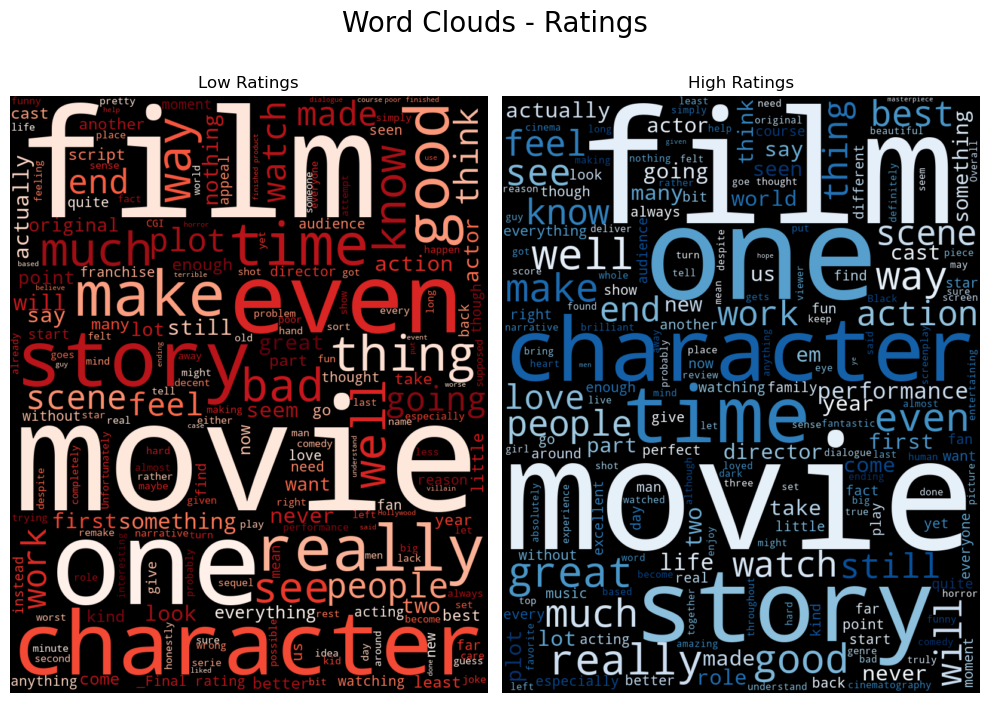

In [23]:
# Make word clouds of raw text
# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                     ).generate(low_text)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                      ).generate(high_text)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Ratings', fontsize=20, y=1.05);

In [24]:
image_folder = "Images"

low_cloud.to_file(os.path.join(image_folder, "low_ratings_wordcloud.png"))
high_cloud.to_file(os.path.join(image_folder, "high_ratings_wordcloud.png"))

In [25]:
# Make a single giant string with entire group of 5 star lemmas
high_lemmas = " ".join( df.loc[filter_high, 'Lemmas-joined'])
# Make a single giant string with entire group of 1 star lemmas
low_lemmas= " ".join( df.loc[filter_low, 'Lemmas-joined'])

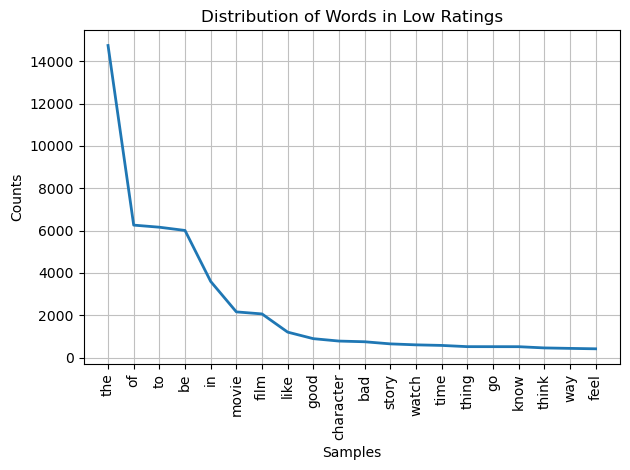

In [26]:
# Split the lemmas into individual token words
low_lemmas_split = low_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
low_dist = FreqDist(low_lemmas_split)
ax = low_dist.plot(20, show = False, title='Distribution of Words in Low Ratings')
plt.tight_layout()
plt.savefig('Images/low_rating_freq_dist.png')

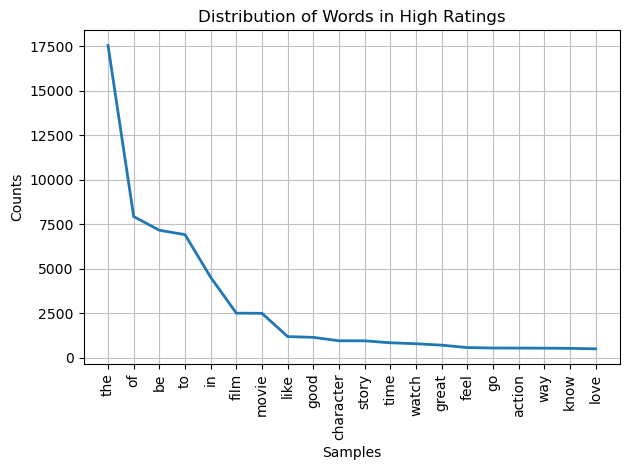

In [27]:
# Split the lemmas into individual token words
high_lemmas_split = high_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
high_dist = FreqDist(high_lemmas_split)
ax = high_dist.plot(20, show = False, title='Distribution of Words in High Ratings')
plt.tight_layout()
plt.savefig('Images/high_rating_freq_dist.png')

**N-grams**

In [28]:
# Make a single giant string with entire group of 5 star tokens
high_reviews_tokens = " ".join( df.loc[filter_high, 'Tokens-joined'])
# Make a single giant string with entire group of 1 star tokens
low_reviews_tokens = " ".join( df.loc[filter_low, 'Tokens-joined'])

In [29]:
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,rating,target,Tokenized,Lemmatized,Tokens-joined,Lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High-rating,"[A, guilty, pleasure, for, me, personally,, as...","[guilty, pleasure, personally, love, the, Grea...","A guilty pleasure for me personally, as I love...",guilty pleasure personally love the Great Esca...
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low-rating,"[The, first, underwhelmed, me,, but, this, one...","[the, underwhelme, straight, bore, of, course,...","The first underwhelmed me, but this one straig...",the underwhelme straight bore of course see Hu...


In [30]:
high_reviews_tokens_exploded_list = df.loc[filter_high, 'Tokenized'].explode().astype(str).to_list()
high_reviews_tokens_exploded_list[:5]

['A', 'guilty', 'pleasure', 'for', 'me']

In [31]:
low_reviews_tokens_exploded_list = df.loc[filter_low, 'Tokenized'].explode().astype(str).to_list()
low_reviews_tokens_exploded_list[:5]

['The', 'first', 'underwhelmed', 'me,', 'but']

In [32]:
# Instantiate a measures objects for Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [33]:
bigram_finder_low = nltk.BigramCollocationFinder.from_words(low_reviews_tokens_exploded_list)

bigram_finder_high = nltk.BigramCollocationFinder.from_words(high_reviews_tokens_exploded_list)

In [34]:
bigrams_scores_low = bigram_finder_low.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_low[:10]

[(('of', 'the'), 0.006257196172628737),
 (('in', 'the'), 0.003712232500893318),
 (('to', 'be'), 0.002259101917655934),
 (('to', 'the'), 0.002112200738476198),
 (('is', 'a'), 0.002036764997816334),
 (('and', 'the'), 0.0018898638186365983),
 (('the', 'film'), 0.0016397347838170485),
 (('in', 'a'), 0.0013737245404375272),
 (('on', 'the'), 0.001326080914757613),
 (('with', 'the'), 0.0013181403104776273)]

In [35]:
bigrams_scores_high = bigram_finder_high.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_high[:10]

[(('of', 'the'), 0.00713399606881895),
 (('in', 'the'), 0.003681740628523346),
 (('to', 'the'), 0.0025376405596777897),
 (('is', 'a'), 0.0025043818367462326),
 (('and', 'the'), 0.001998849248186568),
 (('one', 'of'), 0.0017859934214246042),
 (('to', 'be'), 0.0017161501032683347),
 (('with', 'the'), 0.0014733614258679694),
 (('for', 'the'), 0.0013968663631253888),
 (('in', 'a'), 0.001320371300382808)]

In [36]:
df_bigram_scores_high = pd.DataFrame(bigrams_scores_high, columns=['Words','Frequency'])
df_bigram_scores_high.head()

,Words,Frequency
0,"(of, the)",0.007134
1,"(in, the)",0.003682
2,"(to, the)",0.002538
3,"(is, a)",0.002504
4,"(and, the)",0.001999


In [37]:
# remove stopwords

In [38]:
df_bigram_scores_low = pd.DataFrame(bigrams_scores_low, columns=['Words','Frequency'])
df_bigram_scores_low.head()

,Words,Frequency
0,"(of, the)",0.006257
1,"(in, the)",0.003712
2,"(to, be)",0.002259
3,"(to, the)",0.002112
4,"(is, a)",0.002037
